# Predict size of cluster from text content

### TODO:  Look in to custom cross-validation (ie; I want to train on the earliest 80 % of stories, evaluate on the latest 20 %!)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.utils import shuffle

%matplotlib inline

import lib.helper as helper

In [141]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [99]:
# Import various metrics by which to judge a model's performance
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Regression type measurements
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Import the ML models to try
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Tools for evaluating the model by running it repeatedly
# with variants of the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

## 01.  Create features, labels, train-val-test split

In [4]:
# Load the corpus
df = pd.read_csv("working/RSS_clustered_louvain.csv")

In [5]:
# A quick utility function to pre-process the text
df["tokens"] = df["clean_text"].apply(helper.preprocess_description)
df['phrased_tokens'] = helper.get_phrased_nouns(df['clean_text'])

# Create variable for cluster size
df_size = pd.DataFrame(df['cluster'].value_counts())
df_size['cluster_label'] = df_size.index
df_size.columns = ['cluster_size', 'cluster']
df_size.head()

df = df.merge(df_size, on="cluster", how="left")

df = df[df['cluster'] != -1]
#df['cluster_size'] = np.where(df['cluster']==-1, 0.0, df['cluster_size'])

# Take a look at the features and labels
df[['cluster_size', 'tokens', 'phrased_tokens']].head()

,cluster_size,tokens,phrased_tokens
4,863,"[syria, war, turkey, warn, europ, new, migrant...","[syria_turkey, europ, presid_erdogan, syria]"
29,82,"[trump, news, presid, lash, amid, widespread, ...","[presid, afghan, donald_trump, oval_offic, hur..."
33,59,"[berni, sander, take, victori, lap, iowa, stat...","[berni_sander, iowa, state, fair, soapbox, iow..."
34,6,"[itali, success, eject, far, right, leader, sa...","[itali_salvini, matteo_salvini, leagu, europ]"
44,82,"[trump, launch, angri, attack, grace, star, hu...","[grace, hurrican_dorian, ms, mess, american, m..."
...,...,...,...
31379,20,"[trump, coward, complicit, russia, bounti, cla...","[russia, ex, navi_seal, donald_trump]"
31383,505,"[insid, amsterdam, red, light, district, sex, ...","[amsterdam, pm, mark, rutt, amsterdam, red, li..."
31385,291,"[kim, jong, threaten, ww, south, korea, dirti,...","[kim_jong, ww, south_korea, north_korea, kim_j..."
31391,584,"[far, bank, england, predict, quick, econom, b...","[bank_england, quick, econom, uk, gdp]"


In [149]:
# vectorizer = TfidfVectorizer(decode_error="ignore", max_features=1000)
vectorizer = CountVectorizer(decode_error="ignore", max_features=5000)

# Create feature vectors
X = vectorizer.fit_transform(df['phrased_tokens'].apply(" ".join))

# Create Labels
y = np.asarray(df['cluster_size'].astype(float))

# Check that worked
print(X.shape, y.shape)

# Split the data, save 'test' for final pass
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

(6131, 5000) (6131,)


In [200]:
# Define the measurements we want to make (GridSearch will default to MSE)
#scoring = {'MSE': make_scorer(mean_squared_error),
#           'MAE': make_scorer(mean_absolute_error)}

parameters = {'alpha':[0.01, 0.03, 0.05, 0.07, 0.1, 0.5, 1.0, 2.0],
              'l1_ratio': [0.0, 0.5, 1.0]}

model = ElasticNet()

# Perform cross-validated grid-search
clf = GridSearchCV(estimator=model,
                   cv=5,
                   param_grid=parameters,
                   return_train_score=True,
                   n_jobs=10,
                   refit=True)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)

In [201]:
# Look at the performance of each hyperparameter combination
pd.DataFrame(clf.cv_results_)\
  [['params', 'mean_test_score', 'std_test_score']]\
  .sort_values("mean_test_score", ascending=False)

,params,mean_test_score,std_test_score
11,"{'alpha': 0.07, 'l1_ratio': 1.0}",0.512408,0.039508
14,"{'alpha': 0.1, 'l1_ratio': 1.0}",0.507856,0.036951
8,"{'alpha': 0.05, 'l1_ratio': 1.0}",0.497218,0.042776
1,"{'alpha': 0.01, 'l1_ratio': 0.5}",0.493689,0.018599
5,"{'alpha': 0.03, 'l1_ratio': 1.0}",0.440955,0.055947
0,"{'alpha': 0.01, 'l1_ratio': 0.0}",0.438684,0.018627
4,"{'alpha': 0.03, 'l1_ratio': 0.5}",0.394158,0.019221
17,"{'alpha': 0.5, 'l1_ratio': 1.0}",0.348737,0.020684
7,"{'alpha': 0.05, 'l1_ratio': 0.5}",0.340354,0.019307
3,"{'alpha': 0.03, 'l1_ratio': 0.0}",0.328666,0.018862


In [202]:
def help_get_coefs(fitted_model, feature_names):
    """
    Gets ordered table of coefficient names and magnitudes
    """
    df = pd.DataFrame({"name": feature_names,
                       "coefficient": fitted_model.coef_})
    
    # MAGNITUDES rather than VALUE determine importance
    df['abs_value'] = df['coefficient'].apply(abs)
    
    return df.sort_values("abs_value", ascending=False)

# In this call, retrieving final (selected and retrained)
# estimator from the grid search
coef_table = help_get_coefs(clf.best_estimator_, list(vectorizer.get_feature_names()))

coef_table

,name,coefficient,abs_value
2587,lago,490.790869,490.790869
2917,meir,474.237190,474.237190
101,al_shabaab,453.459174,453.459174
102,al_shabab,427.861630,427.861630
4649,ukrainian_airlin,423.377077,423.377077
...,...,...,...
1900,hajizadeh,0.000000,0.000000
1902,halfquot,-0.000000,0.000000
1903,hall,-0.000000,0.000000
1904,halloween,-0.000000,0.000000


In [209]:
# How many features ultimately selected?
# (they're regularised to NEAR zero, so need a tolerance)
coef_table[coef_table['abs_value'] >= 2.0]

,name,coefficient,abs_value
2587,lago,490.790869,490.790869
2917,meir,474.237190,474.237190
101,al_shabaab,453.459174,453.459174
102,al_shabab,427.861630,427.861630
4649,ukrainian_airlin,423.377077,423.377077
...,...,...,...
2818,march,2.336151,2.336151
4079,si,-2.197575,2.197575
1500,european_union,-2.180733,2.180733
3959,saturday,2.053651,2.053651


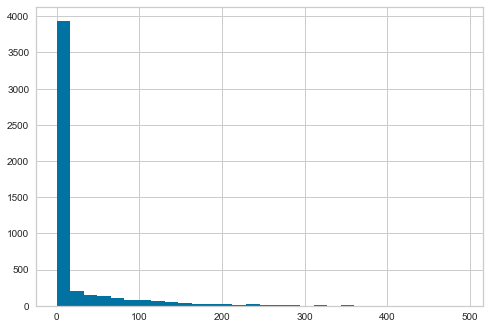

In [212]:
coef_table['abs_value'].hist(bins=30)

## Diagnostic Plots
I'm, to some degree, improvising my own because no single python package quite does everything I'd expect R to do for a linear regression...

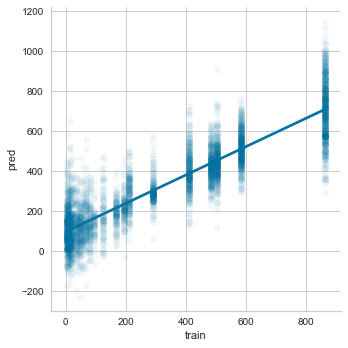

In [204]:
temp_df = pd.DataFrame({"train": y_train,
                        "pred": y_pred})

# Note this isn't the line of the actual regression model.
sns.lmplot(x="train", y="pred", data=temp_df, scatter_kws={"alpha":0.05})

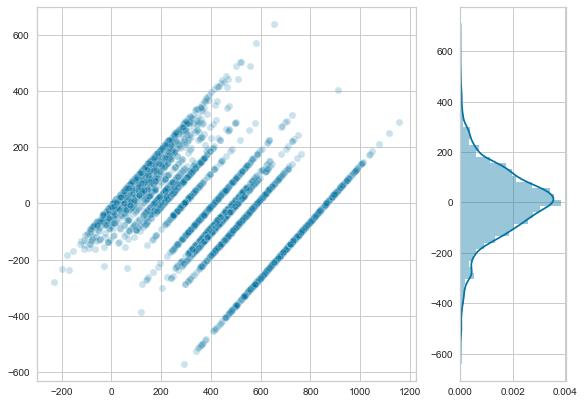

In [205]:
def help_plot_residuals(fitted_model, X, y):
    """
    Utility function:  Plot residual values for a given model
    and features + predictions
    """
    predicted = fitted_model.predict(X)
    residuals = predicted - y
    
    f = plt.figure(constrained_layout=True)
    gs = f.add_gridspec(3, 3)
    f_ax0 = f.add_subplot(gs[:, :-1])
    f_ax1 = f.add_subplot(gs[:, -1])
    
    # Residuals vs predicted
    sns.scatterplot(x=predicted, y=residuals, alpha=0.2, ax=f_ax0)
    
    # Hist of residuals
    sns.distplot(a=residuals, hist=True, vertical=True, ax=f_ax1)


help_plot_residuals(clf.best_estimator_, X_train, y_train)

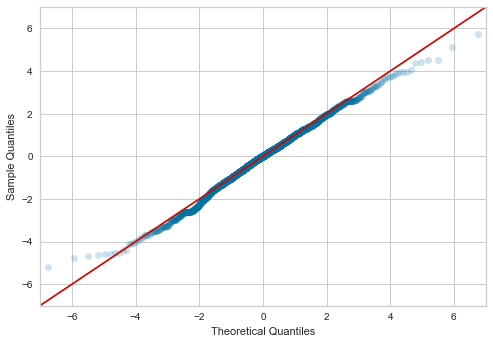

In [206]:
# Q-Q plot to gauge suitability of normality assumption
res = clf.best_estimator_.predict(X_train) - y_train

fig = sm.qqplot(res, stats.t, fit=True, line='45', alpha=0.2)
plt.show()

## Examine feature significance using an equivalent model in StatsModels

In [184]:
# Fit a traditional Linear Regression Model so that we can examine the p-values and r2 values
# of different features

import scipy.stats as stats
import statsmodels.api as sm
from patsy import dmatrices

In [185]:
df_stats = pd.DataFrame(data=X_train.todense(), columns=list(vectorizer.get_feature_names()))
df_stats.head()

df_stats['StorySize'] = y_train